In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten, MultiHeadAttention, LayerNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Bidirectional, Attention

In [12]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)

    # Match the dimensions of the attention output
    attention_output_dim = attention_output.shape[-1]
    attention_output = Dense(attention_output_dim)(attention_output)

    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward part
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(attention_output_dim)(ffn_output) # Match the dimensions of the attention output
    ffn_output = Dropout(dropout)(ffn_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return sequence_output

In [13]:
data = pd.read_csv('E:/merged_data.csv')
df = data
X = []

Y = []
window_size = 100
for i in range(1, len(df) - window_size - 1, 1):
    first_feature = df.iloc[i, 1]
    second_feature = df.iloc[i, 2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append([(df.iloc[i + j, 1] - first_feature) / first_feature, (df.iloc[i + j, 2] - second_feature) / second_feature])
    temp2.append((df.iloc[i + window_size, 1] - first_feature) / first_feature)
    X.append(np.array(temp).reshape(100, 2))
    Y.append(np.array(temp2).reshape(1, 1))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42,shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)

train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,2)
test_X = test_X.reshape(test_X.shape[0],1,100,2)

In [15]:
# Input layer
inputs = Input(shape=(1, 100, 2))

# Model definition
model = tf.keras.Sequential()

# CNN layers
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(inputs)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(128, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Flatten())(x)

# Transformer encoder layer
x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=512, dropout=0.1)

# LSTM layers with Attention
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Attention()([x, x])
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100, return_sequences=False))(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(1, activation='linear')(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [16]:
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=32, verbose=1, shuffle=True)
model.evaluate(test_X, test_Y)

Epoch 1/100
17/17 [==============================] - 19s 243ms/step - loss: 0.4871 - mse: 0.4871 - mae: 0.4173 - val_loss: 0.2350 - val_mse: 0.2350 - val_mae: 0.3024
Epoch 2/100
17/17 [==============================] - 1s 58ms/step - loss: 0.1268 - mse: 0.1268 - mae: 0.2412 - val_loss: 0.0526 - val_mse: 0.0526 - val_mae: 0.1520
Epoch 3/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0765 - mse: 0.0765 - mae: 0.1948 - val_loss: 0.1439 - val_mse: 0.1439 - val_mae: 0.2733
Epoch 4/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0837 - mse: 0.0837 - mae: 0.2042 - val_loss: 0.0461 - val_mse: 0.0461 - val_mae: 0.1440
Epoch 5/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0753 - mse: 0.0753 - mae: 0.1796 - val_loss: 0.1807 - val_mse: 0.1807 - val_mae: 0.3003
Epoch 6/100
17/17 [==============================] - 1s 60ms/step - loss: 0.1069 - mse: 0.1069 - mae: 0.2170 - val_loss: 0.0358 - val_mse: 0.0358 - val_mae: 0.1399
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0890 - val_loss: 0.0105 - val_mse: 0.0105 - val_mae: 0.0757
Epoch 52/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0840 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0744
Epoch 53/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0786 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0612
Epoch 54/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0815 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0900
Epoch 55/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0806 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0712
Epoch 56/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0739 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0703
Epoch 57/1

5/5 [==============================] - 0s 20ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0663


[0.007409927900880575, 0.007409927900880575, 0.06630443781614304]

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

# Calculate MAE, RMSE, and R^2
mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
print('Mean Absolute Error (MAE): %f' % mae)

rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
print('Root Mean Squared Error (RMSE): %f' % rmse)

r2 = r2_score(test_Y.reshape(-1, 1), yhat_probs)
print('R2 Score: %f' % r2)

Mean Absolute Error (MAE): 0.066304
Root Mean Squared Error (RMSE): 0.086081
R2 Score: 0.992553


In [18]:
# Predict the values using the trained model
predictions = model.predict(test_X)

# Reverse the normalization process
def denormalize(value, first_value):
    return value * first_value + first_value

denormalized_predictions = np.empty_like(predictions)
denormalized_test_Y = np.empty_like(test_Y)

# Apply denormalization
for i in range(len(predictions)):
    first_value = df.iloc[i + window_size, 1]
    denormalized_predictions[i] = denormalize(predictions[i], first_value)
    denormalized_test_Y[i] = denormalize(test_Y[i], first_value)
    
# Compare denormalized predictions with actual values
for i in range(len(denormalized_predictions)):
    print(f"Prediction: {denormalized_predictions[i][0].item():.2f} | Actual: {denormalized_test_Y[i][0].item():.2f}")

5/5 [==============================] - 0s 12ms/step
Prediction: 4460.25 | Actual: 4797.09
Prediction: 7468.71 | Actual: 8005.77
Prediction: 5904.89 | Actual: 5660.46
Prediction: 17929.63 | Actual: 17491.52
Prediction: 13850.93 | Actual: 14316.17
Prediction: 13967.08 | Actual: 14035.62
Prediction: 7344.52 | Actual: 7227.86
Prediction: 16065.26 | Actual: 16488.94
Prediction: 14595.07 | Actual: 13910.74
Prediction: 35133.90 | Actual: 34131.78
Prediction: 5704.55 | Actual: 6202.98
Prediction: 19550.04 | Actual: 19087.91
Prediction: 17687.17 | Actual: 15094.41
Prediction: 19805.62 | Actual: 19819.32
Prediction: 8688.64 | Actual: 8077.90
Prediction: 7093.86 | Actual: 7663.74
Prediction: 4887.21 | Actual: 5407.73
Prediction: 8215.86 | Actual: 7747.14
Prediction: 17918.92 | Actual: 16578.28
Prediction: 18623.48 | Actual: 18306.38
Prediction: 17610.77 | Actual: 16803.64
Prediction: 12990.31 | Actual: 12613.81
Prediction: 28158.76 | Actual: 26242.10
Prediction: 5628.34 | Actual: 5439.01
Predicti

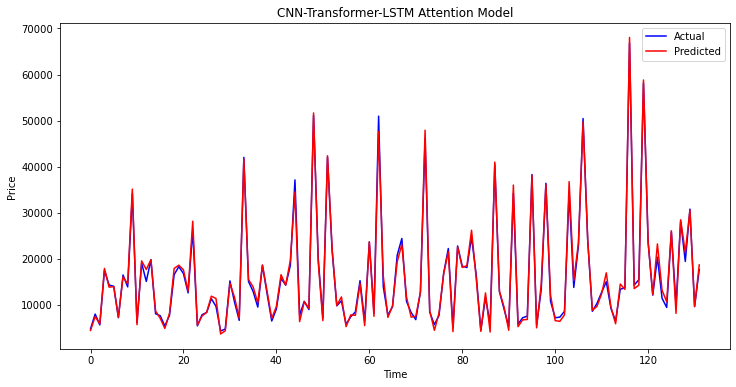

<Figure size 432x288 with 0 Axes>

In [19]:
# Flatten the denormalized_test_Y and denormalized_predictions arrays
denormalized_test_Y_flattened = denormalized_test_Y.flatten()
denormalized_predictions_flattened = denormalized_predictions.flatten()

# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(denormalized_test_Y_flattened, label='Actual', color='blue')
plt.plot(denormalized_predictions_flattened, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('CNN-Transformer-LSTM Attention Model')
plt.show()
# Save the plot as an image file
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')

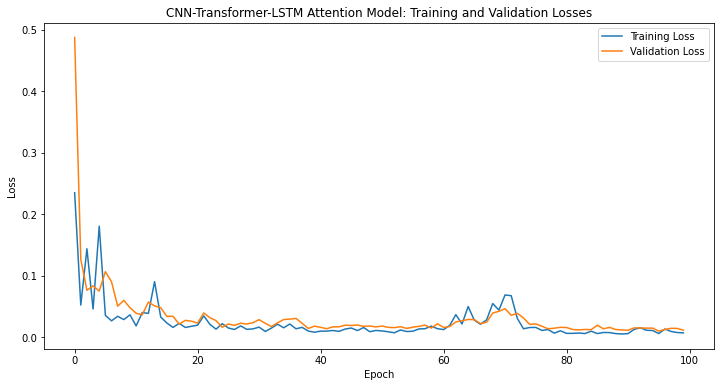

In [20]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Training Loss')
plt.plot(history.history['loss'], label='Validation Loss')
plt.title('CNN-Transformer-LSTM Attention Model: Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()